Импортируем библиотеки необходимые для анализа результатов эксперимента

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import requests

Получаем данные с результатами эксперимента с помощью get запроса

In [2]:
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
request_link = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key='

In [4]:
r_groups_link = requests.get(request_link+groups_link)
r_groups_add_link = requests.get(request_link+groups_add_link)
r_active_studs_link = requests.get(request_link+active_studs_link)
r_checks_link = requests.get(request_link+checks_link)

In [5]:
groups_csv = r_groups_link.json()['href']
groups_add_csv = r_groups_add_link.json()['href']
active_studs_csv = r_active_studs_link.json()['href']
checks_csv = r_checks_link.json()['href']

In [6]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv(groups_csv, sep=';')

# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv(groups_add_csv, sep=',')

# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv(active_studs_csv)

# файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv(checks_csv, sep=';')

Изучаем полученные данные и проверяем типы данных

In [7]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [8]:
groups.dtypes

id      int64
grp    object
dtype: object

In [9]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.dtypes

student_id    int64
dtype: object

In [13]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [15]:
# Обогащаем датасет полученными спустя 2 дня данными
group_data = pd.concat([groups,groups_add])
group_data

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [16]:
# Для исследования влияния новой механики мы будем использовать данные только о тех пользователях, 
# которые в дни эксперимента посещали сайт, т.к. остальные не могли воспользоваться новой механикой 
active_studs = active_studs.rename(columns = {"student_id":"id"})
active_studs = active_studs.merge(group_data, on = "id", how = "left")

In [17]:
active_studs.groupby('grp', as_index = False).agg({"id":"count"})

,grp,id
0,A,1538
1,B,6803


В дни проведения эксперимента сайт посещали пользователи преимущественно из экспериментальной группы. Данный факт поможет в дальнейшем с выбором теста.

In [18]:
# Сопоставляет данные по принадлежности к определенной группе для каждого платящего пользователя
checks = checks.rename(columns = {"student_id":'id'})
checks = checks.merge(active_studs, on = "id", how = "left")
checks

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,NaN
2,25973,690.0,NaN
3,26280,690.0,NaN
4,100300,990.0,B
...,...,...,...
536,5645737,1900.0,B
537,5651566,1900.0,B
538,5662322,1900.0,B
539,5681918,1900.0,B


В датасете выше видно, что у нас есть информация по платящим пользователям, которые не участовали в эксперименте

In [19]:
# Убираем данные по пользователям, которые не попали в эксперимент
checks = checks.dropna(axis = 0)

checks

,id,rev,grp
0,1627,990.0000,A
4,100300,990.0000,B
8,108270,290.0000,B
26,264473,1900.0001,B
27,274352,690.0000,B
...,...,...,...
536,5645737,1900.0000,B
537,5651566,1900.0000,B
538,5662322,1900.0000,B
539,5681918,1900.0000,B


In [20]:
checks.groupby('grp', as_index = False).agg({"id":"count"})

,grp,id
0,A,78
1,B,314


Среди заплативших пользователей также превалирует экспериментальная группа

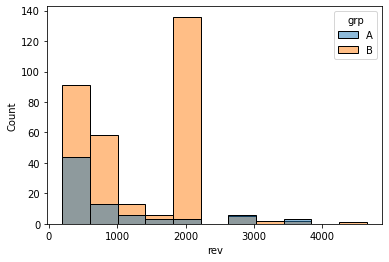

In [21]:
# Посмотрим на распределение дохода у платящих пользователей
sns.histplot(checks, x = 'rev', hue = 'grp')

In [22]:
# считаем arppu (Average Revenue per Paying Users)
checks.groupby('grp').agg({'rev':'mean'})

,rev
grp,
A,933.589744
B,1257.878992


Наблюдается существенное различие по среднему доходу с платящего пользователя. Формируем гипотезы:

    H0 - ARPPU в обоих группах не отличаются, а наблюдаемая разница случайна 
    
    H1 - ARPPU в экспериментальной группе cтатистически значимо отличается от ARPPU в контрольной

Распределение дохода ненормальное + объемы выборок A и Б групп существенное отличаются, поэтому воспользуемся критерием Колмогорова-Смирнова. (Изначально планировал использовать критерий Манна-Уитни, но после прочтения статьи на хабре https://habr.com/ru/companies/avito/articles/709596/ меня озарило;) )

In [23]:
stats.ks_2samp(checks[checks['grp'] == 'A'].rev, checks[checks['grp'] == 'B'].rev, alternative='greater')

KstestResult(statistic=0.323942511840601, pvalue=1.199131957452882e-06)

Результат теста - p_value < 0.05, поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную: ARPPU в экспериментальной группе статистически значимо отличается от ARPPU контрольной группы. Новая механика оплаты услуг на сайте влияет на средний доход с платящего пользователя.

Также для полноты эксперимента проверим, как новая механика влияет на ARPU и CR из активного пользователя в оплату.

In [24]:
# В датасет active_studs добавим данные по доходу и факту покупки для каждого пользователя

active_studs = active_studs.merge(checks[['id','rev']], on = "id", how = 'left').fillna(0)
active_studs['purchase'] = ''
active_studs['purchase'] = active_studs['rev'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
active_studs

,id,grp,rev,purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [26]:
active_studs.groupby('grp', as_index = False).agg({"id":"count"})

,grp,id
0,A,1538
1,B,6803


Тут также различаются объемы двух групп

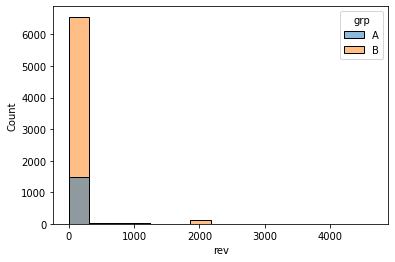

In [27]:
# Посмотрим на распределение дохода c каждого пользователя
sns.histplot(active_studs, x = 'rev', hue = 'grp')

Видим, что доходы с пользователя распределены ненормально, поэтому мы также будем использовать критерий Колмогорова-Смирнова.

In [28]:
# считаем arpu (Average Revenue per User)
active_studs.groupby('grp').agg({'rev':'mean'})

,rev
grp,
A,47.347204
B,58.058798


Наблюдается различие по среднему доходу с каждого пользователя. Формируем гипотезы:

    H0 - ARPU в обоих группах не отличаются, а наблюдаемая разница случайна 
    
    H1 - ARPU в экспериментальной группе cтатистически значимо отличается от ARPU в контрольной

In [30]:
stats.ks_2samp(active_studs[active_studs['grp'] == 'A'].rev, active_studs[active_studs['grp'] == 'B'].rev, alternative='greater')

KstestResult(statistic=0.014308974450383035, pvalue=0.591573086087132)

Результат теста - p_value > 0.05, поэтому мы не отвергаем нулевую гипотезу: ARPU в экспериментальной группе статистически значимо не отличается от ARPU  контрольной группы. Новая механика оплаты услуг на сайте не влияет на средний доход с каждого пользователя.

Такой же критерий применим для конверсии в покупке

In [31]:
# Conversion rate
active_studs.groupby('grp').agg({'purchase':'mean'})

,purchase
grp,
A,0.050715
B,0.046156


Наблюдается различие по уровню конверсии из активного пользователя в покупающего. Формируем гипотезы:

    H0 - CR в обоих группах не отличаются, а наблюдаемая разница случайна 
    
    H1 - CR в экспериментальной группе cтатистически значимо отличается от CR в контрольной

In [36]:
stats.ks_2samp(active_studs[active_studs['grp'] == 'A'].purchase, active_studs[active_studs['grp'] == 'B'].purchase, alternative='greater')

KstestResult(statistic=0.0, pvalue=1.0)

Результат теста - p_value > 0.05, поэтому мы не отвергаем нулевую гипотезу: CR в экспериментальной группе статистически значимо не отличается от CR  контрольной группы. Новая механика оплаты услуг на сайте не влияет на уровень конверсии из активного пользователя в покупающего.

# Выводы

В ходе данного исследования мы изучали влияние новой механики оплаты услуг на сайте. Были составлены две группы и запущен эксперимент:

1. Группа А - для пользователей данной группы механика оплаты оставлась прежней.
2. Группа Б - для пользователей данной группы механика изменилась.

Для анализа эксперимента исследовались 3 метрики:

1. Conversion Rate (CR) - конверсия из активного пользователя в покупающего.
2. ARPU (Average Revenue per User) - средний доход с одного пользователя.
3. ARPPU (Average Revenue Paying per User) - средний доход с одного платящего пользователя.

Из-за отличий объемов обоих групп и ненормального распределения признаков для тестирования гипотез был выбран критерий Колмогорова-Смирнова. Получены следующие результаты:

1. CR и ARPU обоих групп статистически значимо не различаются, а наблюдаемая разница случайна.
2. ARPPU обоих групп статистически значимо различается (p < 0,05), наблюдаемая разница не случайна.

Полученные результаты позволяют утверждать о положительном влиянии новой механики на средний доход платящих пользователей, поэтому рекомендуется обновить механику для всех пользователей. 

Для кратного увеличения дохода рекомендуется дальнейшая работа над повышением Converion Rate.